## loss

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from huggingface_hub import hf_hub_download

realistic_vision_path = hf_hub_download(repo_id="SG161222/Realistic_Vision_V5.1_noVAE", filename="Realistic_Vision_V5.1-inpainting.safetensors")
vae_path = hf_hub_download(repo_id="stabilityai/sd-vae-ft-mse-original", filename="vae-ft-mse-840000-ema-pruned.safetensors")

In [3]:
import sys
sys.path.append('../src')

In [4]:
from config import DatasetConfig, Config, ModelConfig, WandbConfig, EvaluationConfig, TrainConfig

dataset_config = DatasetConfig(
    roboflow_api_key='HNXIsW3WwnidNDQZHexX',
    roboflow_workspace='arked',
    project_name='facades-flzke',
    dataset_version=11,
    data_root='facades_data',
    image_size=512,
)

model_config = ModelConfig(
    model_path=realistic_vision_path,
    vae_path=vae_path,
)

wandb_config = WandbConfig(
    project_name='facades',
)

eval_config=EvaluationConfig(
    prompts=['white facade', 'brick facade'],
)

train_config=TrainConfig(
    checkpoint_folder = wandb_config.project_name + "_checkpoints",
    train_batch_size = 4,
    unet_lr=1e-4,
    text_encoder_lr=1e-4,
    scheduler_num_cycles=4,
    total_steps=1000,
)

config = Config(
    dataset=dataset_config,
    model=model_config,
    wandb=wandb_config,
    eval=eval_config,
    train=train_config,
)

In [8]:
download_roboflow_dataset(config)
set_random_seed(config.seed)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to facades_data in yolov7pytorch:: 100%|██████████| 219/219 [00:00<00:00, 1286.99it/s]


In [9]:
from model import get_models

text_encoder, vae, unet, tokenizer, noise_scheduler, placeholder_token_ids = get_models(
    config.model.model_path,
    config.model.vae_path,
    device=config.device,
    load_from_safetensor=True,
)

loading VAE...
loading model...


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.


In [10]:
import os
import itertools
import wandb
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint
from torch.autograd import Variable

from diffusers import StableDiffusionInpaintPipeline, logging
from diffusers.utils.import_utils import is_xformers_available
from diffusers.optimization import get_scheduler
from peft import LoraConfig, LoraModel
from controlnet_aux import MLSDdetector

The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'


In [13]:
from torch.utils.data import Dataset
from PIL import Image
import random
from pathlib import Path
from typing import Optional
from roboflow import Roboflow
import os
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms
from torchvision.transforms.v2 import functional as TF

import numpy as np
import cv2

from utils import parse_labels, scale_polygons, generate_masks, mask_image, get_images_and_labels_paths

class InpaintLoraDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        tokenizer,
        label_mapping: dict,
        global_caption: Optional[str] = None,
        size=512,
        normalize=True,
        augmentation=True,
        scaling_pixels: int = 0,
        labels_filter: Optional[list] = None,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.augmentation = augmentation

        if not Path(instance_data_root).exists():
            raise ValueError("Instance images root doesn't exists.")

        # Prepare the instance images and masks
        self.imgs, self.labels = get_images_and_labels_paths(instance_data_root)
        self.label_mapping = label_mapping

        self.global_caption = global_caption

        self._length = len(self.imgs)

        self.normalize = normalize
        self.scaling_pixels = scaling_pixels
        self.labels_filter = labels_filter # TODO implement labels filter
        
        self.mean, self.std = self.calculate_mean_std()

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size=self.size),
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(torch.float32),
                transforms.Normalize(mean=self.mean, std=self.std)
                if self.normalize
                else transforms.Lambda(lambda x: x),
            ]
        )

        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize(size=self.size),
                transforms.PILToTensor(),
            ]
        )

    def calculate_mean_std(self):
        means = []
        stds = []

        for img in self.imgs:
            # calculate the mean and std of all the images
            img = cv2.imread(img, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            mean = np.mean(img, axis=(0, 1))
            std = np.std(img, axis=(0, 1))
            means.append(mean)
            stds.append(std)

        mean = np.mean(means, axis=0)
        std = np.mean(stds, axis=0)

        return mean, std

    def transform(self, image, mask):
        
        mask = torch.from_numpy(mask).unsqueeze(0)

        image = self.image_transforms(image)
        mask = self.mask_transforms(mask)

        if self.augmentation:

            while True:
                # Random crop
                i, j, h, w = transforms.RandomCrop.get_params(
                    image, output_size=(self.size, self.size))
                image = TF.crop(image, i, j, h, w)
                mask = TF.crop(mask, i, j, h, w)

                # Check if the mask contains at least one non-zero value
                # TODO find a bug in the mask generation
                # because sometimes the mask is all zeros
                # when the size is not 512 (e.g. 768)
                if torch.sum(mask) > 0:
                    break


            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

        return image, mask
    
    
    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}

        image = Image.open(self.imgs[index])
        polygons = parse_labels(self.labels[index])
        scaled_polygons = scale_polygons(polygons, image.size)
        mask, label = generate_masks(
            scaled_polygons, 
            image.size, 
            scaling_pixels=self.scaling_pixels
        )
        image, mask = self.transform(image, mask)


        example["instance_images"] = image
        example["instance_masks"] = mask
        example["instance_masked_images"] = mask_image(image, example["instance_masks"], invert=True)
        example["instance_masked_values"] = mask_image(image, example["instance_masks"], invert=False)
        
        text = self.label_mapping[label]
        if self.global_caption:
            text += ', ' + self.global_caption.strip()

        example["instance_prompt_ids"] = self.tokenizer(
            text,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

class InpaintingDataLoader(DataLoader):
    def __init__(self, dataset, tokenizer, device, batch_size=1, **kwargs):
        super().__init__(dataset, collate_fn=self.collate_fn, batch_size=batch_size, **kwargs)
        self.tokenizer = tokenizer
        self.device = device

    def collate_fn(self, examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]
        mask_values = [example["instance_masked_values"] for example in examples]
        masked_image_values = [
            example["instance_masked_images"] for example in examples
        ]
        mask = [example["instance_masks"] for example in examples]

        # Concat class and instance examples for prior preservation.
        # We do this to avoid doing two forward passes.
        if examples[0].get("class_prompt_ids", None) is not None:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]
            mask_values += [example["class_masks"] for example in examples]
            masked_image_values += [
                example["class_masked_images"] for example in examples
            ]

        pixel_values = (
            torch.stack(pixel_values).to(memory_format=torch.contiguous_format).float()
        )
        mask_values = (
            torch.stack(mask_values).to(memory_format=torch.contiguous_format).float()
        )
        masked_image_values = (
            torch.stack(masked_image_values).to(memory_format=torch.contiguous_format).float()
        )
        mask = (
            torch.stack(mask).to(memory_format=torch.contiguous_format).float()
        )

        input_ids = self.tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
            "mask_values": mask_values,
            "masked_image_values": masked_image_values,
            "mask": mask,
        }

        return batch

def download_roboflow_dataset(config):
    rf = Roboflow(api_key=config.dataset.roboflow_api_key)
    project = rf.workspace(config.dataset.roboflow_workspace).project(config.dataset.project_name)
    dataset = project.version(config.dataset.dataset_version).download("yolov7", location=config.dataset.data_root)

In [14]:
label_mapping = get_label_mapping(os.path.join(config.dataset.data_root, "data.yaml"))

train_dataset = InpaintLoraDataset(
    instance_data_root= os.path.join(config.dataset.data_root, "train"),
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    global_caption=config.prompt.global_caption,
    size=config.dataset.image_size,
    normalize=config.dataset.normalize_images,
    scaling_pixels=config.dataset.scaling_pixels,
)

valid_dataset = InpaintLoraDataset(
    instance_data_root=os.path.join(config.dataset.data_root, "valid"),
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    global_caption=config.prompt.global_caption,
    size=config.dataset.image_size,
    normalize=False,
    augmentation=False,
)

train_dataloader = InpaintingDataLoader(
    train_dataset,
    batch_size=config.train.train_batch_size,
    tokenizer=tokenizer,
    device=config.device,
)
valid_dataloader = InpaintingDataLoader(
    valid_dataset,
    batch_size=config.train.eval_batch_size,
    tokenizer=tokenizer,
    device=config.device,
)

# Freeze all weights
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if config.train.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if config.train.use_xformers and is_xformers_available():
    unet.enable_xformers_memory_efficient_attention()

params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
for param in params_to_freeze:
    param.requires_grad = False

if config.log_wandb:
    wandb.init(
        project=config.wandb.project_name, 
        entity=config.wandb.entity_name,
        config=config,
        id=config.wandb.run_name,
        tags=config.wandb.tags,
    )
    wandb.watch(unet)
    wandb.watch(text_encoder)

if config.train.train_unet:
    unet_peft = LoraConfig(
        r=config.lora.rank,
        lora_alpha=config.lora.alpha,
        target_modules=config.lora.unet_target_modules,
        lora_dropout=0.1,
        bias='none',
    )

    unet = LoraModel(unet, unet_peft, config.lora.unet_adapter_name)
    print_trainable_parameters(unet, "unet")

    params_to_optimize = [
        {
            "params": itertools.chain(unet.parameters()),
            "lr": config.train.unet_lr,
        },
    ]

if config.train.train_text_encoder:
    text_encoder_peft = LoraConfig(
        r=config.lora.rank,
        lora_alpha=config.lora.alpha,
        target_modules=config.lora.text_encoder_target_modules,
        lora_dropout=0.1,
        bias='none',
    )

    text_encoder = LoraModel(text_encoder, text_encoder_peft, config.lora.text_encoder_adapter_name)
    print_trainable_parameters(text_encoder, "text_encoder")

    params_to_optimize += [
        {
            "params": itertools.chain(text_encoder.parameters()),
            "lr": config.train.text_encoder_lr,
        }
    ]

optimizer_lora = optim.AdamW(
    params_to_optimize,
    lr=config.train.learning_rate,
    weight_decay=config.train.weight_decay,
)

if config.train.train_unet:
    unet.train()
    
if config.train.train_text_encoder:
    text_encoder.train()

lr_scheduler_lora = get_scheduler(
    config.train.scheduler_type,
    optimizer=optimizer_lora,
    num_warmup_steps=config.train.scheduler_warmup_steps,
    num_training_steps=config.train.total_steps,
    num_cycles=config.train.scheduler_num_cycles,
)

if not os.path.exists(config.train.checkpoint_folder):
    os.makedirs(config.train.checkpoint_folder)
    print(f"Directory '{config.train.checkpoint_folder}' created.")
else:
    print(f"Directory '{config.train.checkpoint_folder}' already exists.")

loss_sum = 0.0
progress_bar = tqdm(range(config.train.total_steps))
progress_bar.set_description("Steps")
global_step = 0

if config.train.text_encoder_train_ratio < 1.0:
    text_encoder_steps = math.ceil(config.train.total_steps * config.train.text_encoder_train_ratio)
else:
    text_encoder_steps = config.train.total_steps

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maidacundo (arked). Use `wandb login --relogin` to force relogin


Model: unet
trainable params: 2492928 || all params: 862028292 || trainable%: 0.28919329250970804
Model: text_encoder
trainable params: 1327104 || all params: 124387584 || trainable%: 1.0669103437204794
Directory 'facades_checkpoints' created.


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
train_dataset = InpaintLoraDataset(
    instance_data_root= os.path.join(config.dataset.data_root, "train"),
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    global_caption=config.prompt.global_caption,
    size=config.dataset.image_size,
    normalize=False,
    scaling_pixels=config.dataset.scaling_pixels,
)

valid_dataset = InpaintLoraDataset(
    instance_data_root=os.path.join(config.dataset.data_root, "valid"),
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    global_caption=config.prompt.global_caption,
    size=config.dataset.image_size,
    normalize=False,
    augmentation=False,
)

train_dataloader = InpaintingDataLoader(
    train_dataset,
    batch_size=config.train.train_batch_size,
    tokenizer=tokenizer,
    device=config.device,
)
valid_dataloader = InpaintingDataLoader(
    valid_dataset,
    batch_size=config.train.eval_batch_size,
    tokenizer=tokenizer,
    device=config.device,
)

In [22]:
batch = next(iter(train_dataloader))

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


In [25]:
batch.keys()

dict_keys(['input_ids', 'pixel_values', 'mask_values', 'masked_image_values', 'mask'])

In [29]:
optimizer_lora.zero_grad()

In [ ]:
def loss_step(
    batch,
    unet,
    vae,
    text_encoder,
    scheduler,
    t_mutliplier=1.0,
    mixed_precision=False,
    mask_temperature=1.0,
    vae_scale_factor=8,
    criterion='mse',
):
    weight_dtype = torch.float32

    # encode the image
    latents = vae.encode(
            batch["pixel_values"].to(dtype=weight_dtype).to(unet.device)
        ).latent_dist.sample()


    # encode the masked image
    masked_image_latents = vae.encode(
                batch["masked_image_values"].to(dtype=weight_dtype).to(unet.device)
            ).latent_dist.sample()
    masked_image_latents = masked_image_latents * vae.config.scaling_factor
    latents = latents * vae.config.scaling_factor

    # scale the mask
    mask = F.interpolate(
                batch["mask"].to(dtype=weight_dtype).to(unet.device),
                scale_factor=1 / 8,
            )

    noise = torch.randn_like(latents)
    bsz = latents.shape[0]

    timesteps = torch.randint(
        0,
        int(scheduler.config.num_train_timesteps * t_mutliplier),
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    latent_model_input = torch.cat(
            [noisy_latents, mask, masked_image_latents], dim=1
        )

    if mixed_precision:
        with torch.cuda.amp.autocast():

            encoder_hidden_states = text_encoder(
                batch["input_ids"].to(text_encoder.device)
            )[0]

            model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    else:
        encoder_hidden_states = text_encoder(
            batch["input_ids"].to(text_encoder.device)
        )[0]

        model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    if scheduler.config.prediction_type == "epsilon":
        target = noise
    elif scheduler.config.prediction_type == "v_prediction":
        target = scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

    if batch.get("mask", None) is not None:

        mask = (
            batch["mask"]
            .to(model_pred.device)
            .reshape(
                model_pred.shape[0], 1, model_pred.shape[2] * vae_scale_factor, model_pred.shape[3] * vae_scale_factor
            )
        )
        # resize to match model_pred
        mask = F.interpolate(
            mask.float(),
            size=model_pred.shape[-2:],
            mode="nearest",
        )

        mask = mask.pow(mask_temperature)

        mask = mask / mask.max()

        model_pred = model_pred * mask

        target = target * mask

    if criterion == 'mse':
        loss = (
            F.mse_loss(model_pred.float(), target.float(), reduction="none")
            .mean([1, 2, 3])
            .mean()
        )
    elif criterion == 'ssim':
        loss = (
            ssim(model_pred.float(), target.float(), data_range=1, size_average=False)
        )

    return loss


In [30]:
t_mutliplier=0.8
scheduler = noise_scheduler 

In [31]:
weight_dtype = torch.float32

# encode the image
latents = vae.encode(
        batch["pixel_values"].to(dtype=weight_dtype).to(unet.device)
    ).latent_dist.sample()


# encode the masked image
masked_image_latents = vae.encode(
            batch["masked_image_values"].to(dtype=weight_dtype).to(unet.device)
        ).latent_dist.sample()
masked_image_latents = masked_image_latents * vae.config.scaling_factor
latents = latents * vae.config.scaling_factor

# scale the mask
mask = F.interpolate(
            batch["mask"].to(dtype=weight_dtype).to(unet.device),
            scale_factor=1 / 8,
        )

noise = torch.randn_like(latents)
bsz = latents.shape[0]

timesteps = torch.randint(
    0,
    int(scheduler.config.num_train_timesteps * t_mutliplier),
    (bsz,),
    device=latents.device,
)
timesteps = timesteps.long()

noisy_latents = scheduler.add_noise(latents, noise, timesteps)

latent_model_input = torch.cat(
        [noisy_latents, mask, masked_image_latents], dim=1
    )

if mixed_precision:
    with torch.cuda.amp.autocast():

        encoder_hidden_states = text_encoder(
            batch["input_ids"].to(text_encoder.device)
        )[0]

        model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
else:
    encoder_hidden_states = text_encoder(
        batch["input_ids"].to(text_encoder.device)
    )[0]

    model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
if scheduler.config.prediction_type == "epsilon":
    target = noise
elif scheduler.config.prediction_type == "v_prediction":
    target = scheduler.get_velocity(latents, noise, timesteps)
else:
    raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

if batch.get("mask", None) is not None:

    mask = (
        batch["mask"]
        .to(model_pred.device)
        .reshape(
            model_pred.shape[0], 1, model_pred.shape[2] * vae_scale_factor, model_pred.shape[3] * vae_scale_factor
        )
    )
    # resize to match model_pred
    mask = F.interpolate(
        mask.float(),
        size=model_pred.shape[-2:],
        mode="nearest",
    )

    mask = mask.pow(mask_temperature)

    mask = mask / mask.max()

    model_pred = model_pred * mask

    target = target * mask


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 6.00 GiB total capacity; 5.03 GiB already allocated; 0 bytes free; 5.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
loss_lora = loss_step(
    batch,
    unet,
    vae,
    text_encoder,
    noise_scheduler,
    t_mutliplier=0.8,
    mixed_precision=True,
    mask_temperature=config.train.mask_temperature,
    criterion='ssim',
)

In [ ]:
loss_lora.backward()
loss_sum += loss_lora.detach().item()

## color loss

In [61]:
from PIL import Image
import torch
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [62]:
image = cv2.imread('images/img_kvist.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [65]:
img_tensor = F.to_tensor(image)

noise = torch.randn_like(img_tensor)
pred_noise = torch.randn_like(img_tensor)

timestep = torch.tensor(20)

In [67]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler()
scheduler.set_timesteps(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


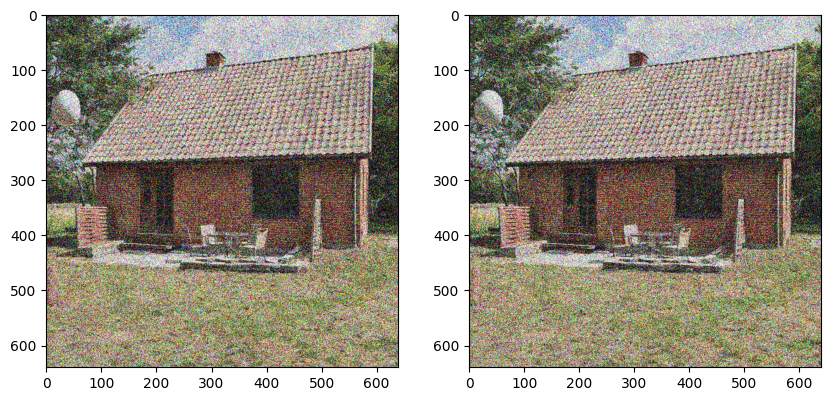

In [97]:
timestep = torch.tensor(100)

noisy_image = scheduler.add_noise(img_tensor, noise, timestep)
pred_noise_image = scheduler.add_noise(img_tensor, pred_noise, timestep)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(pred_noise_image.permute(1, 2, 0))

In [112]:
from pytorch_msssim import ssim
from torch.nn.functional import mse_loss

img_mse_losses = []
img_ssim_losses = []

noise_mse_losses = []
noise_ssim_losses = []

for t in range(1000):

    timestep = torch.tensor(t)

    ssim_img = 0
    mse_img = 0
    ssim_noise = 0
    mse_noise = 0

    for i in range(4):
        noise = torch.randn_like(img_tensor)
        pred_noise = torch.randn_like(img_tensor)

        noisy_image = scheduler.add_noise(img_tensor, noise, timestep)
        pred_noise_image = scheduler.add_noise(img_tensor, pred_noise, timestep)

        ssim_img += 1-ssim(noisy_image.unsqueeze(0), pred_noise_image.unsqueeze(0), data_range=1, size_average=True)
        mse_img += mse_loss(noisy_image.unsqueeze(0), pred_noise_image.unsqueeze(0), reduction='mean')

        ssim_noise += 1-ssim(noise.unsqueeze(0), pred_noise.unsqueeze(0), data_range=1, size_average=True)
        mse_noise += mse_loss(noise.unsqueeze(0), pred_noise.unsqueeze(0), reduction='mean')

    ssim_img /= 4
    mse_img /= 4
    ssim_noise /= 4
    mse_noise /= 4

    img_mse_losses.append(mse_img)
    img_ssim_losses.append(ssim_img)

    noise_mse_losses.append(mse_noise)
    noise_ssim_losses.append(ssim_noise)

In [110]:
1-ssim(noise.unsqueeze(0), pred_noise.unsqueeze(0), data_range=1, size_average=True)

tensor(0.9946)

In [111]:
mse_loss(noise.unsqueeze(0), pred_noise.unsqueeze(0), reduction='mean')

tensor(2.0012)

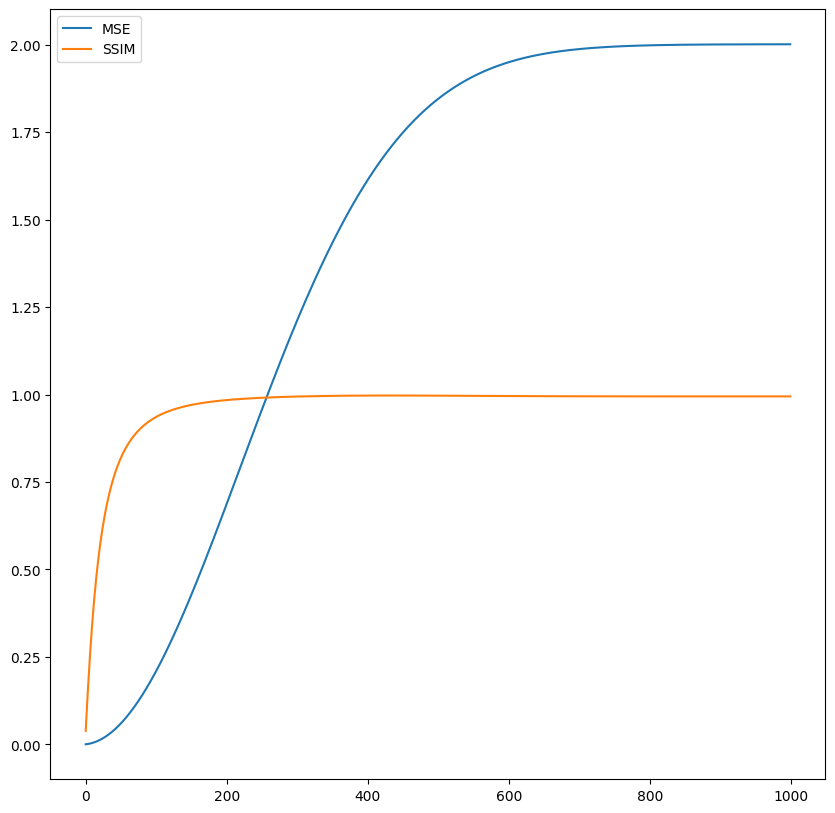

In [113]:
# plot the losses over time
plt.figure(figsize=(10, 10))

plt.plot(mse_losses, label='MSE')
plt.plot(ssim_losses, label='SSIM')
plt.legend()
plt.show()